In [494]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 一、二八轮动策略介绍

二八轮动策略又叫做大小盘轮动策略。“二”代表数量占比20%左右的大盘权重股，“八”代表数量占比80%左右的中小盘股票，二八轮动就是指在大盘股与小盘股中间不断切换，轮流持有。（该项目中大盘权重股以沪深300指数代表，小盘权重股以中证500指数代表）

策略原理为动量效应（Momentum effect），又叫惯性效应。由Jegadeesh和Titman（1993）提出的，是指股票的收益率有延续原来的运动方向的趋势，即过去一段时间收益率较高的股票在未来获得的收益率仍会高于过去收益率较低的股票。

具体策略：通过判断沪深300和中证500指数的趋势寻找上涨行情中的市场热点，满仓配置近20个交易日上涨较多的指数。若均下跌，则落袋为安。为了减少调仓带来的手续费，限制两次调仓至少间隔十个交易日。

### 二、数据范围

In [495]:
#读取数据,时间范围是2014年1月至2021年4月
data = pd.read_excel('指数行情序列.xlsx')
data = data.iloc[:-2,:]

### 三、策略实现

In [496]:
#设置参数
#计算N个交易日的涨跌幅
N = 20

In [497]:
#计算沪深300和中证500指数N个交易日的动量（momentum）
data["hs300_mom"]=data.沪深300.pct_change(periods = N)
data["zz500_mom"]=data.中证500.pct_change(periods = N)
#计算沪深300和中证500指数每天涨跌幅
data["hs300_dpct"] = data.沪深300/data.沪深300.shift(1) - 1
data["zz500_dpct"] = data.中证500/data.中证500.shift(1) - 1
#删除nan值
data.dropna(subset = ['hs300_mom'],inplace = True)

In [498]:
def strategy(small,big):
    
    """调仓条件：满仓配置近20个交易日上涨较多的指数。若均下跌，则落袋为安。
      （此处先不考虑调仓时间的限制）
       small : 中证500指数
       big   : 沪深300指数 """
    
    if big<0 and small<0:
        return 'empty'
    if small>big:
        return 'zh500'
    if big > small:
        return 'hs300'
    else:
        return False

In [499]:
#为了减少调仓带来的手续费，限制两次调仓至少间隔十个交易日
#大小盘N日动量
big = data["hs300_mom"].values
small = data["zz500_mom"].values
#交易日（以index形式记录）
trade_day = data.index.values
#记录调仓的交易日（以index形式记录）
style_change_day = []
#记录每次调仓后的风格
style = []

for i in range(trade_day.shape[0]):
    #记录第一次"调仓"（申购）
    if i == 0:
        style.append(strategy(small[i],big[i]))
        style_change_day.append(trade_day[i])
    else:
        #在距上一次调仓日10个交易日以后才作判断
        if trade_day[i]-style_change_day[-1] >= 10:
            new_style = strategy(small[i],big[i])
            if new_style != style[-1]:
                style.append(new_style)
                style_change_day.append(trade_day[i])

In [500]:
#合并数据
style_pd = pd.DataFrame({'style':style},index =style_change_day)
df = data.join(style_pd,how = 'outer')
df['style'].fillna(method = 'ffill',inplace = True)
df['时间'] = pd.to_datetime(df['时间'],format='%Y-%m-%d')

In [501]:
#收盘才能确定style，持仓发生在style变动的后一天
df['pos']= df['style'].shift(1)
#调仓日期
df['relocate_time'] = df.loc[style_change_day,'时间']
#计算策略每日涨跌幅
df.loc[df['pos'] == 'zh500','strategy_dpct'] = df["zz500_dpct"] 
df.loc[df['pos'] == 'hs300','strategy_dpct'] = df["hs300_dpct"]
df.loc[df['pos'] == 'empty','strategy_dpct'] = 0

In [502]:
#计算net(不考虑手续费情况下)
df['hs300_net'] = (df["沪深300"]/df["沪深300"].iloc[0]) 
df['zz500_net'] = (df["中证500"]/df["中证500"].iloc[0])
df['strategy_net'] = (1+df['strategy_dpct']).cumprod()

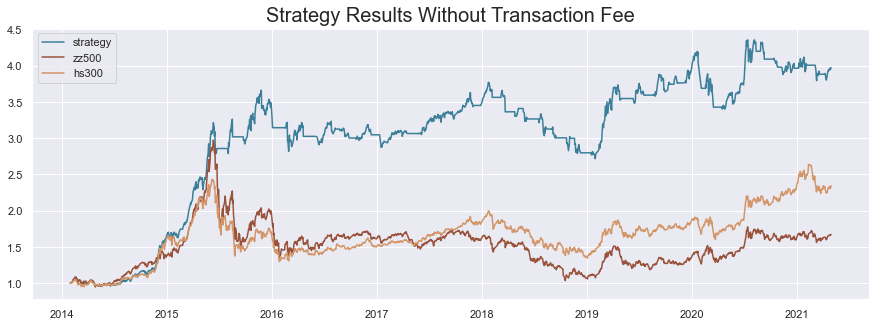

In [503]:
#可视化
sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = df['strategy_net'].values, label='strategy',color='#3c7f99')
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = df['zz500_net'].values,label='zz500', color='#99533c')
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = df['hs300_net'].values,label='hs300', color='#d39669')
plt.title('Strategy Results Without Transaction Fee',fontsize=20)
plt.show()

In [504]:
#计算net(考虑手续费情况下)
#调仓费率：申购费率0.12%，赎回费率0.375%（数据来源：支付宝「南方中证500ETF联接A」，赎回费率按持有7-180天的平均费率计算）
purchase_rate = 0.0012
sell_rate = 0.00375
df.loc[(df['relocate_time'].notnull())&(df['pos'] != 'empty')& 
       (df['style'] == 'empty'),'strategy_dpct_adjust'] = (df['strategy_dpct'] + 1)*(1-sell_rate)-1
df.loc[(df['relocate_time'].notnull())&(df['pos'] == 'empty')& 
       (df['style'] != 'empty'),'strategy_dpct_adjust'] = (df['strategy_dpct'] + 1)*(1-purchase_rate)-1
df.loc[(df['relocate_time'].notnull())&(df['pos'] != 'empty')& 
       (df['style'] != 'empty'),'strategy_dpct_adjust'] = (df['strategy_dpct'] + 1)*(1-sell_rate)*(1-purchase_rate)-1
df.loc[df['relocate_time'].isnull(), 'strategy_dpct_adjust'] = df['strategy_dpct']
df['strategy_net_adjust'] = (1+df['strategy_dpct_adjust']).cumprod()

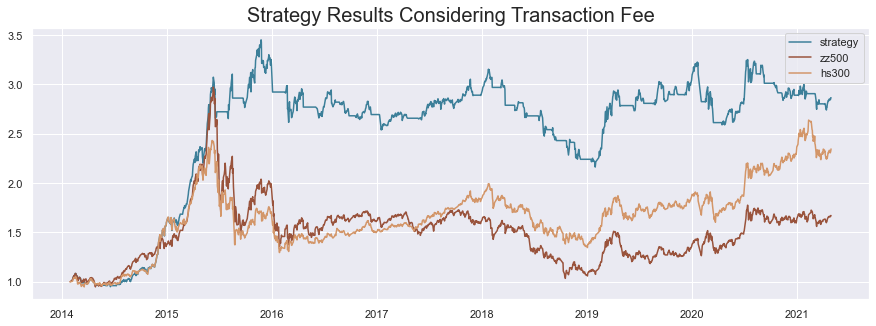

In [505]:
#可视化
sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = df['strategy_net_adjust'].values, label='strategy',color='#3c7f99')
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = df['zz500_net'].values,label='zz500', color='#99533c')
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = df['hs300_net'].values,label='hs300', color='#d39669')
plt.title('Strategy Results Considering Transaction Fee',fontsize=20)
plt.show()

In [506]:
def evaluate_strategy(data,strategy,trade_time = '2014-02-10 00:00:00'):
    """计算策略的年化收益率和最大回撤"""
    df = data.dropna(subset = ['pos'])
    time = df[df.时间 >= trade_time].时间
    annual_return = (df[strategy].iloc[-1] **(365/(time.iloc[-1]-time.iloc[0]).days))-1
    #计算当日之前的资金曲线的最高点
    df['max_values'] = df[strategy].expanding().max()
    #计算与之前最高点的回撤
    df['retracement'] = df[strategy]/df['max_values'] -1
    max_retrace = df.sort_values(by ='retracement').iloc[0]['retracement']
    
    return annual_return,max_retrace

In [507]:
#评价策略效果
print('二八轮动策略（计算调仓费用）年化收益率为:',str(round(evaluate_strategy(df,'strategy_net_adjust')[0]*100,2)) + '%')
print('二八轮动策略（计算调仓费用）最大回撤为:',str(round(evaluate_strategy(df,'strategy_net_adjust')[1]*100,2)) + '%')
print('二八轮动策略（不计算调仓费用）年化收益率为:',str(round(evaluate_strategy(df,'strategy_net')[0]*100,2)) + '%')
print('二八轮动策略（不计算调仓费用）最大回撤为:',str(round(evaluate_strategy(df,'strategy_net')[1]*100,2)) + '%')
print('持有中证500年化收益率为:',str(round(evaluate_strategy(df,'zz500_net')[0]*100,2)) + '%')
print('持有中证500最大回撤为:',str(round(evaluate_strategy(df,'zz500_net')[1]*100,2)) + '%')
print('持有沪深300年化收益率为:',str(round(evaluate_strategy(df,'hs300_net')[0]*100,2)) + '%')
print('持有沪深300最大回撤为:',str(round(evaluate_strategy(df,'hs300_net')[1]*100,2)) + '%')
print('调仓次数:',df[df['relocate_time'].notnull()].shape[0],'次')

二八轮动策略（计算调仓费用）年化收益率为: 15.69%
二八轮动策略（计算调仓费用）最大回撤为: -37.34%
二八轮动策略（不计算调仓费用）年化收益率为: 21.06%
二八轮动策略（不计算调仓费用）最大回撤为: -27.95%
持有中证500年化收益率为: 7.37%
持有中证500最大回撤为: -65.2%
持有沪深300年化收益率为: 12.53%
持有沪深300最大回撤为: -46.7%
调仓次数: 99 次


### 四、如果不限制调仓时间

策略中限制了两次调仓至少间隔十个交易日，目的是为了减少调仓带来的手续费。那让我们来看一下如果不限制调仓时间，会有多大的收益吧

In [508]:
#如果不限制调仓次数
toy_df = data.copy()
toy_df['时间'] = pd.to_datetime(toy_df['时间'],format='%Y-%m-%d')
toy_df.loc[toy_df.hs300_mom > toy_df.zz500_mom,'style'] = 'hs300'
toy_df.loc[toy_df.hs300_mom < toy_df.zz500_mom,'style'] = 'zz500'
toy_df.loc[(toy_df['hs300_mom']<0) & (toy_df['zz500_mom']<0),'style'] = 'empty'
#相等时维持原来仓位
toy_df['style'].fillna(method = 'ffill',inplace = True)
#持仓比策略晚一天
toy_df['pos'] = toy_df['style'].shift(1)
#toy_df.dropna(subset = ['pos'],inplace = True)
toy_df['relocate_time'] = toy_df[toy_df['style'] != toy_df['style'].shift(1)].时间

In [509]:
#计算策略每日涨跌幅
toy_df.loc[toy_df['pos'] == 'zz500','strategy_dpct'] = toy_df["zz500_dpct"] 
toy_df.loc[toy_df['pos'] == 'hs300','strategy_dpct'] = toy_df["hs300_dpct"]
toy_df.loc[toy_df['pos'] == 'empty','strategy_dpct'] = 0
#计算net
toy_df['strategy_net'] = (1+toy_df['strategy_dpct']).cumprod()
toy_df['hs300_net'] = (toy_df["沪深300"]/toy_df["沪深300"].iloc[0]) 
toy_df['zz500_net'] = (toy_df["中证500"]/toy_df["中证500"].iloc[0])
#加上交易费用
purchase_rate = 0.0012
sell_rate = 0.00375
toy_df.loc[(toy_df['relocate_time'].notnull())&(toy_df['pos'] != 'empty')& 
       (toy_df['style'] == 'empty'),'strategy_dpct_adjust'] = (toy_df['strategy_dpct'] + 1)*(1-sell_rate)-1
toy_df.loc[(toy_df['relocate_time'].notnull())&(toy_df['pos'] == 'empty')& 
       (toy_df['style'] != 'empty'),'strategy_dpct_adjust'] = (toy_df['strategy_dpct'] + 1)*(1-purchase_rate)-1
toy_df.loc[(toy_df['relocate_time'].notnull())&(toy_df['pos'] != 'empty')& 
       (toy_df['style'] != 'empty'),'strategy_dpct_adjust'] = (toy_df['strategy_dpct'] + 1)*(1-sell_rate)*(1-purchase_rate)-1
toy_df.loc[toy_df['relocate_time'].isnull(), 'strategy_dpct_adjust'] = toy_df['strategy_dpct']
toy_df['strategy_net_adjust'] = (1+toy_df['strategy_dpct_adjust']).cumprod()

In [510]:
print('「不限制调仓时间」且「不计算调仓费用」的情况下：')
print('伪二八轮动策略年化收益率为:',str(round(evaluate_strategy(toy_df,'strategy_net')[0]*100,2)) + '%')
print('伪二八轮动策略最大回撤为:',str(round(evaluate_strategy(toy_df,'strategy_net')[1]*100,2)) + '%')
print('持有中证500年化收益率为:',str(round(evaluate_strategy(toy_df,'zz500_net')[0]*100,2)) + '%')
print('持有中证500最大回撤为:',str(round(evaluate_strategy(toy_df,'zz500_net')[1]*100,2)) + '%')
print('持有沪深300年化收益率为:',str(round(evaluate_strategy(toy_df,'hs300_net')[0]*100,2)) + '%')
print('持有沪深300最大回撤为:',str(round(evaluate_strategy(toy_df,'hs300_net')[1]*100,2)) + '%')
print('调仓次数:',toy_df[toy_df['relocate_time'].notnull()].shape[0],'次')

「不限制调仓时间」且「不计算调仓费用」的情况下：
伪二八轮动策略年化收益率为: 18.95%
伪二八轮动策略最大回撤为: -33.71%
持有中证500年化收益率为: 7.37%
持有中证500最大回撤为: -65.2%
持有沪深300年化收益率为: 12.53%
持有沪深300最大回撤为: -46.7%
调仓次数: 215 次


令人惊讶的是，不限制调仓时间后，策略的收益率不升反降（也许进场和出场时机不同，会有不同的结果，待确认）。但确实能发现在2014年2月到2021年4月的这段时间，限制调仓次数的二八轮动策略在不算手续费的情况下有21.06%的年化收益率和-27.95%的最大回撤，明显优于不加调仓限制的二八轮动策略。更别提考虑调仓费用后，可怜的策略并没有跑赢中证500.

In [511]:
print('「考虑调仓费用」的情况下：')
print('伪二八轮动策略年化收益率为:',str(round(evaluate_strategy(toy_df,'strategy_net_adjust')[0]*100,2)) + '%')
print('伪二八轮动策略最大回撤为:',str(round(evaluate_strategy(toy_df,'strategy_net_adjust')[1]*100,2)) + '%')

「考虑调仓费用」的情况下：
伪二八轮动策略年化收益率为: 8.19%
伪二八轮动策略最大回撤为: -50.47%


这样的结果和我的理性认知是不太相符的：不加时间限制的策略明明应该是最优解，为什么结果却不尽如人意？我想从数据上发现点问题。首先，我们来看一下这215次的调仓间隔多少个交易日

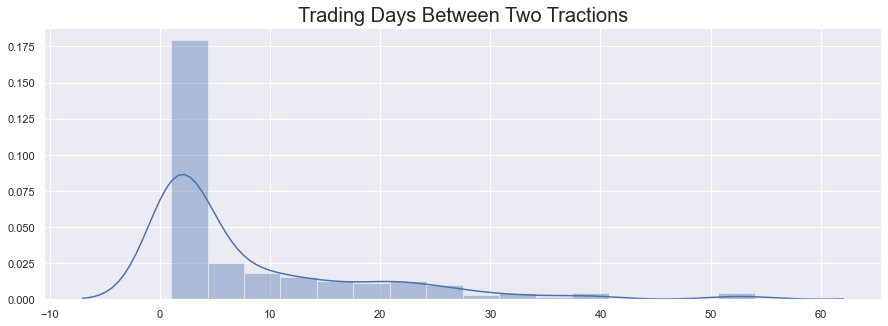

In [512]:
#计算两次调仓间相隔多少个交易日
toy_relocate = toy_df[toy_df['relocate_time'].notnull()]
toy_relocate['idx'] = toy_relocate.index
gaps = toy_relocate.index - toy_relocate['idx'].shift(1) 
sns.distplot(gaps)
plt.title('Trading Days Between Two Tractions',fontsize=20)
plt.show()
#可以发现大部分绝大部份交易间隔都在5个交易日以内

有的53%的调仓发生在3个交易日以内，有接近30%的调仓发生在相邻两个交易日

In [513]:
gaps.value_counts().sort_values(ascending=False)[:4]

1.0    64
2.0    29
3.0    23
4.0    11
dtype: int64

仔细查看这部分数据时发现，由于我们计算的是前20个交易日的涨跌幅，存在滞后性，在股市波动比较大的时候，策略的结果也会频繁变动，表现就是频繁调仓来追涨杀跌。因为策略总是后反应一步，所以在一段时间内总是“踩空”。

二八轮动策略本身是利用惯性来收益，但如果太依赖惯性，结果表现也不会太好。有点类似算法中的过拟合，局部最优解往往不是全局最优。

这样看来，「两次调仓需要间隔十个交易日以上」这个限制带来的意义不仅是减少手续费，更多的是减小波动，往全局最优靠拢。

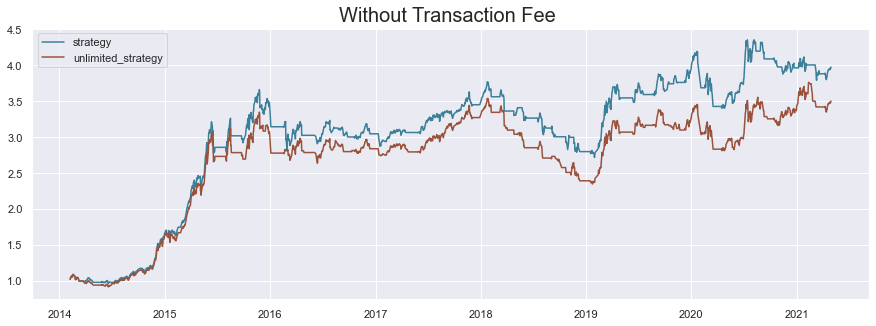

In [518]:
#比较下两种策略的收益：蓝色为我们最开始实现的二八轮动策略，红色为不限制调仓时间的二八轮动策略
sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = df['strategy_net'].values, label='strategy',color='#3c7f99')
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = toy_df['strategy_net'].values,label='unlimited_strategy', color='#99533c')
plt.title('Without Transaction Fee ',fontsize=20)
plt.show()

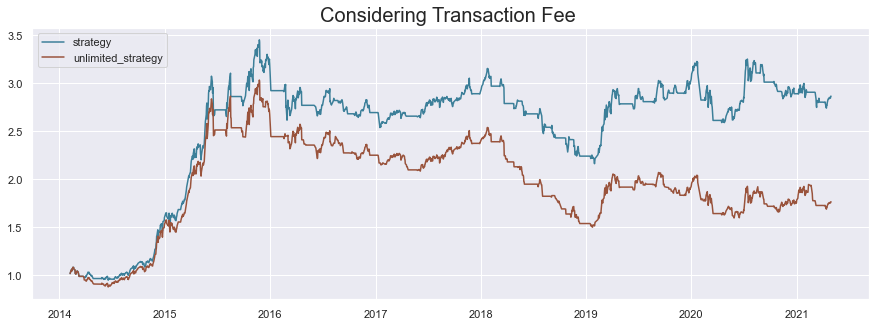

In [519]:
#考虑交易费用的情况下，两者的差距就更大了
sns.set(rc={'figure.figsize':(15, 5)})
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = df['strategy_net_adjust'].values, label='strategy',color='#3c7f99')
sns.lineplot(x = pd.to_datetime(df['时间'].values), y = toy_df['strategy_net_adjust'].values,label='unlimited_strategy', color='#99533c')
plt.title('Considering Transaction Fee ',fontsize=20)
plt.show()